In [1]:
# If you run this notebook on Google Colaboratory, uncomment the below to install automl_alex.
#!pip install -U -q automl-alex

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

import automl_alex
from automl_alex import DataPrepare

print(automl_alex.__version__)

/root/anaconda3/envs/automl_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023.3.10


In [2]:
RANDOM_SEED = 42

# Load Data

In [3]:
dataset = fetch_openml(name='adult', version=1, as_frame=True)
# convert target to binary
dataset.target = dataset.target.astype('category').cat.codes
dataset.data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                    dataset.target,
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED,)
X_train.shape, X_test.shape

((39073, 14), (9769, 14))

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39073 entries, 37193 to 15795
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             39073 non-null  category
 1   workclass       36851 non-null  category
 2   fnlwgt          39073 non-null  float64 
 3   education       39073 non-null  category
 4   education-num   39073 non-null  float64 
 5   marital-status  39073 non-null  category
 6   occupation      36842 non-null  category
 7   relationship    39073 non-null  category
 8   race            39073 non-null  category
 9   sex             39073 non-null  category
 10  capitalgain     39073 non-null  category
 11  capitalloss     39073 non-null  category
 12  hoursperweek    39073 non-null  category
 13  native-country  38396 non-null  category
dtypes: category(12), float64(2)
memory usage: 1.3 MB


As we can see, the data is quite dirty, there are object/category features and nans. But the **model is successfully trained even in such a dirty dataset**      
[RUS] Как мы видим, данные довольно грязные, есть object/category признаки и nans. Но модель успешно обучаеться даже таком грязном датасете

# Data Cleaning (DataPrepare)
before entering the AutoML, the data goes through a full cycle of pre-processing in DataPrepare Class     
[RUS] до того как попасть в AutoML, данные проходят полный цикл предобработки в классе DataPrepare. Давайте расмотрим его отдельно

In [6]:
%%time
de = DataPrepare(clean_and_encod_data=True,
                cat_encoder_names=['HelmertEncoder','OneHotEncoder'], # Encoders list for Generator cat encodet features
                clean_nan=True, # fillnan
                clean_outliers=True, # method='IQR', threshold=2,
                drop_invariant=True, # drop invariant features (data.nunique < 2)
                num_generator_features=False, # Generator interaction Num Features
                normalization=True, # normalization data (StandardScaler)
                cat_features=None, # DataPrepare can auto detect categorical features
                random_state=RANDOM_SEED,
                verbose=3)
clean_X_train = de.fit_transform(X_train)

18:21:37 | Source data shape: (39073, 14)
18:21:37 | ##################################################
18:21:37 | ! START preprocessing Data
18:21:37 | - Auto detect cat features: 12
18:21:37 | > Binary Features
18:21:37 | > Clean Categorical Features
18:21:37 | > Transform Categorical Features.
18:21:38 |  - Encoder: HelmertEncoder ADD features: 123
18:21:39 |  - Encoder: OneHotEncoder ADD features: 135
18:21:39 |   No nans features
18:21:39 | > CleanOutliers
18:21:39 | Num of outlier detected: 253 in Feature education-num
18:21:39 | Proportion of outlier detected: 0.6 %
18:21:39 | Num of outlier detected: 560 in Feature fnlwgt
18:21:39 | Proportion of outlier detected: 1.4 %
18:21:39 | > Normalization Features
18:21:39 | ##################################################
18:21:39 | Final data shape: (39073, 274)
18:21:39 | Total ADD columns: 260
18:21:39 | Time fit data_preproc: 2.03 sec
18:21:39 | ##################################################


CPU times: user 1.73 s, sys: 243 ms, total: 1.97 s
Wall time: 2.05 s


In [7]:
clean_X_train.head(5)

,sex,HelmertEncoder_age_3,HelmertEncoder_workclass_7,HelmertEncoder_education_14,HelmertEncoder_education-num_14,HelmertEncoder_marital-status_5,HelmertEncoder_occupation_13,HelmertEncoder_relationship_4,HelmertEncoder_race_3,HelmertEncoder_capitalgain_3,...,HelmertEncoder_native-country_29,HelmertEncoder_native-country_30,HelmertEncoder_native-country_31,HelmertEncoder_native-country_32,HelmertEncoder_native-country_33,HelmertEncoder_native-country_34,HelmertEncoder_native-country_35,HelmertEncoder_native-country_36,HelmertEncoder_native-country_37,HelmertEncoder_native-country_38
0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
2,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
3,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771


<img src="./img/magic.gif" width="400">

In [8]:
clean_X_test = de.transform(X_test)

18:21:44 | ##################################################
18:21:44 | ! Start Transform Data
18:21:44 | > Clean Binary Features
18:21:44 | > Clean Categorical Features
18:21:44 | > Transform Categorical Features.
18:21:44 |  - Encoder: HelmertEncoder ADD features: 123
18:21:44 |  - Encoder: OneHotEncoder ADD features: 135
18:21:44 | > Normalization Features
18:21:44 | ##################################################
18:21:44 | Final data shape: (9769, 274)
18:21:44 | Total ADD columns: 260
18:21:44 | ##################################################


In [9]:
clean_X_test.head(5)

,sex,HelmertEncoder_age_3,HelmertEncoder_workclass_7,HelmertEncoder_education_14,HelmertEncoder_education-num_14,HelmertEncoder_marital-status_5,HelmertEncoder_occupation_13,HelmertEncoder_relationship_4,HelmertEncoder_race_3,HelmertEncoder_capitalgain_3,...,HelmertEncoder_native-country_29,HelmertEncoder_native-country_30,HelmertEncoder_native-country_31,HelmertEncoder_native-country_32,HelmertEncoder_native-country_33,HelmertEncoder_native-country_34,HelmertEncoder_native-country_35,HelmertEncoder_native-country_36,HelmertEncoder_native-country_37,HelmertEncoder_native-country_38
0,1,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
1,0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
2,1,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
3,0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771


## Save and Load
separate transform allows us to save and transfer processing to new data 
[RUS] раздельный transform позволяет нам сохранять и переносить обработку на новые данные

In [10]:
de.save('de', folder='./save/')

18:21:54 | Save DataPrepare


In [11]:
de_new = DataPrepare()
de_new = de.load('de', folder='./save/')

In [12]:
de_new.transform(X_test).head(5)

18:22:04 | ##################################################
18:22:04 | ! Start Transform Data
18:22:04 | > Clean Binary Features
18:22:04 | > Clean Categorical Features
18:22:04 | > Transform Categorical Features.
18:22:04 |  - Encoder: HelmertEncoder ADD features: 123
18:22:04 |  - Encoder: OneHotEncoder ADD features: 135
18:22:04 | > Normalization Features
18:22:04 | ##################################################
18:22:04 | Final data shape: (9769, 274)
18:22:04 | Total ADD columns: 260
18:22:04 | ##################################################


,sex,HelmertEncoder_age_3,HelmertEncoder_workclass_7,HelmertEncoder_education_14,HelmertEncoder_education-num_14,HelmertEncoder_marital-status_5,HelmertEncoder_occupation_13,HelmertEncoder_relationship_4,HelmertEncoder_race_3,HelmertEncoder_capitalgain_3,...,HelmertEncoder_native-country_29,HelmertEncoder_native-country_30,HelmertEncoder_native-country_31,HelmertEncoder_native-country_32,HelmertEncoder_native-country_33,HelmertEncoder_native-country_34,HelmertEncoder_native-country_35,HelmertEncoder_native-country_36,HelmertEncoder_native-country_37,HelmertEncoder_native-country_38
0,1,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
1,0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
2,1,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
3,0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771
4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,-0.054519,-0.039161,-0.031479,-0.038636,-0.030532,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771


# Feature Engineering

## Categorical Features 
### Encoders

In [13]:
# available Encoders:
automl_alex._encoders.cat_encoders_names

{'HashingEncoder': category_encoders.hashing.HashingEncoder,
 'SumEncoder': category_encoders.sum_coding.SumEncoder,
 'BackwardDifferenceEncoder': category_encoders.backward_difference.BackwardDifferenceEncoder,
 'OneHotEncoder': category_encoders.one_hot.OneHotEncoder,
 'HelmertEncoder': category_encoders.helmert.HelmertEncoder,
 'BaseNEncoder': category_encoders.basen.BaseNEncoder,
 'CountEncoder': category_encoders.count.CountEncoder}

you can use any encoders for categorical features, combining their results (if you have enough memory)

In [14]:
X_train[['workclass','marital-status']].head(5)

,workclass,marital-status
37193,Private,Married-civ-spouse
31093,State-gov,Married-civ-spouse
33814,Local-gov,Married-civ-spouse
14500,Private,Divorced
23399,Self-emp-not-inc,Widowed


In [15]:
de = DataPrepare(
    cat_encoder_names=['OneHotEncoder',], # Encoders list for Generator cat encodet features
    )  
clean_X_train = de.fit_transform(X_train[['workclass','marital-status']])

18:22:27 | Source data shape: (39073, 2)
18:22:27 | ##################################################
18:22:27 | ! START preprocessing Data
18:22:27 | - Auto detect cat features: 2
18:22:27 | > Clean Categorical Features
18:22:27 | > Transform Categorical Features.
18:22:27 |  - Encoder: OneHotEncoder ADD features: 16
18:22:27 |   No nans features
18:22:27 | > CleanOutliers
18:22:27 | ##################################################
18:22:27 | Final data shape: (39073, 18)
18:22:27 | Total ADD columns: 16
18:22:27 | Time fit data_preproc: 0.19 sec
18:22:27 | ##################################################


In [16]:
clean_X_train.head(5)

,workclass,marital-status,OneHotEncoder_workclass_1,OneHotEncoder_workclass_2,OneHotEncoder_workclass_3,OneHotEncoder_workclass_4,OneHotEncoder_workclass_5,OneHotEncoder_workclass_6,OneHotEncoder_workclass_7,OneHotEncoder_workclass_8,OneHotEncoder_workclass_9,OneHotEncoder_marital-status_1,OneHotEncoder_marital-status_2,OneHotEncoder_marital-status_3,OneHotEncoder_marital-status_4,OneHotEncoder_marital-status_5,OneHotEncoder_marital-status_6,OneHotEncoder_marital-status_7
0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,4,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


**Encoder selection is important part of all AutoML**    

## Numerical Features

### Clean NANs

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39073 entries, 37193 to 15795
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             39073 non-null  category
 1   workclass       36851 non-null  category
 2   fnlwgt          39073 non-null  float64 
 3   education       39073 non-null  category
 4   education-num   39073 non-null  float64 
 5   marital-status  39073 non-null  category
 6   occupation      36842 non-null  category
 7   relationship    39073 non-null  category
 8   race            39073 non-null  category
 9   sex             39073 non-null  category
 10  capitalgain     39073 non-null  category
 11  capitalloss     39073 non-null  category
 12  hoursperweek    39073 non-null  category
 13  native-country  38396 non-null  category
dtypes: category(12), float64(2)
memory usage: 1.3 MB


In [18]:
X_train.isnull().any().any()

True

In [19]:
de = DataPrepare(
    clean_nan=True,
    verbose=0,
    )
clean_X_train = de.fit_transform(X_train)

In [20]:
clean_X_train.isnull().any().any()

False

## Clean Outliers
remove outliers from your data.    
Available two methods solution based on "z score" and solution based on "IQR". default "IQR" 

<img src="./img/boxplot.png" width="600">

In [21]:
# add dataset whis more num features
dataset = fetch_openml(name='credit-g', version=1, as_frame=True)
dataset.target = dataset.target.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=RANDOM_SEED,)
X_train.head(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
29,<0,60.0,delayed previously,business,6836.0,<100,>=7,3.0,male single,none,4.0,no known property,63.0,none,own,2.0,skilled,1.0,yes,yes
535,>=200,21.0,critical/other existing credit,education,2319.0,<100,<1,2.0,male div/sep,none,1.0,car,33.0,none,rent,1.0,skilled,1.0,none,yes
695,no checking,6.0,existing paid,used car,1236.0,500<=X<1000,1<=X<4,2.0,male single,none,4.0,life insurance,50.0,none,rent,1.0,skilled,1.0,none,yes


<Axes: >

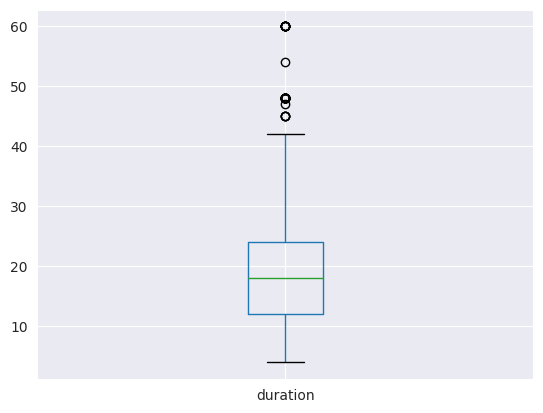

In [22]:
X_train.boxplot(column=['duration',])

In [23]:
de = DataPrepare(
    clean_outliers=True,
    outliers_method='IQR', # method : ['IQR', 'z_score',]
    outliers_threshold=1.5,
    )
clean_X_train = de.fit_transform(X_train)

18:22:41 | Source data shape: (800, 20)
18:22:41 | ##################################################
18:22:41 | ! START preprocessing Data
18:22:41 | - Auto detect cat features: 13
18:22:41 | > Binary Features
18:22:41 | > Clean Categorical Features
18:22:41 | > Transform Categorical Features.
18:22:41 |  - Encoder: HelmertEncoder ADD features: 39
18:22:41 |  - Encoder: CountEncoder ADD features: 13
18:22:41 |   No nans features
18:22:41 | > CleanOutliers
18:22:41 | Num of outlier detected: 18 in Feature age
18:22:41 | Proportion of outlier detected: 2.2 %
18:22:41 | Num of outlier detected: 54 in Feature duration
18:22:41 | Proportion of outlier detected: 6.8 %
18:22:41 | Num of outlier detected: 5 in Feature existing_credits
18:22:41 | Proportion of outlier detected: 0.6 %
18:22:41 | Num of outlier detected: 58 in Feature credit_amount
18:22:41 | Proportion of outlier detected: 7.3 %
18:22:42 | ##################################################
18:22:42 | Final data shape: (800, 78)

In [24]:
clean_X_train.boxplot(column=['duration',])

<Axes: >

try different values threshold and method

### Generator interaction Num Features
Numerical interaction generator features: A/B, A*B, A-B, A+B

In [25]:
de = DataPrepare(
                num_generator_features=True, # Generator interaction Num Features
                num_generator_operations=['/','*','-',],
                )
clean_X_train = de.fit_transform(X_train)

18:22:42 | Source data shape: (800, 20)
18:22:42 | ##################################################
18:22:42 | ! START preprocessing Data
18:22:42 | - Auto detect cat features: 13
18:22:42 | > Binary Features
18:22:42 | > Clean Categorical Features
18:22:42 | > Transform Categorical Features.
18:22:42 |  - Encoder: HelmertEncoder ADD features: 39
18:22:42 |  - Encoder: CountEncoder ADD features: 13
18:22:42 |   No nans features
18:22:42 | > CleanOutliers
18:22:42 | Num of outlier detected: 6 in Feature age
18:22:42 | Proportion of outlier detected: 0.8 %
18:22:42 | Num of outlier detected: 10 in Feature duration
18:22:42 | Proportion of outlier detected: 1.2 %
18:22:42 | Num of outlier detected: 38 in Feature credit_amount
18:22:42 | Proportion of outlier detected: 4.8 %
18:22:42 | > Generate interaction Num Features
18:22:43 |  ADD features: 75
18:22:43 | ##################################################
18:22:43 | Final data shape: (800, 153)
18:22:43 | Total ADD columns: 133
18:2

In [26]:
clean_X_train.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,age_*_duration,age_*_existing_credits,age_*_credit_amount,age_*_installment_commitment,duration_*_existing_credits,duration_*_credit_amount,duration_*_installment_commitment,existing_credits_*_credit_amount,existing_credits_*_installment_commitment,credit_amount_*_installment_commitment
0,1,48.0,1,1,6836.0,1,1,3.0,1,1,...,3024.0,126.0,430668.0,189.0,96.0,328128.0,144.0,13672.0,6.0,20508.0
1,2,21.0,2,2,2319.0,1,2,2.0,2,1,...,693.0,33.0,76527.0,66.0,21.0,48699.0,42.0,2319.0,2.0,4638.0
2,3,6.0,3,3,1236.0,2,3,2.0,1,1,...,300.0,50.0,61800.0,100.0,6.0,7416.0,12.0,1236.0,2.0,2472.0
3,3,21.0,4,4,5003.0,3,3,1.0,3,1,...,609.0,58.0,145087.0,29.0,42.0,105063.0,21.0,10006.0,2.0,5003.0
4,3,12.0,3,5,886.0,3,3,4.0,3,1,...,252.0,21.0,18606.0,84.0,12.0,10632.0,48.0,886.0,4.0,3544.0


### Normalization

In [27]:
de = DataPrepare(
    normalization=True, # normalization data - StandardScaler
    verbose=0,
    )
clean_X_train = de.fit_transform(X_train)
clean_X_train.head(5)

,num_dependents,own_telephone,foreign_worker,HelmertEncoder_checking_status_2,HelmertEncoder_credit_history_3,HelmertEncoder_savings_status_3,HelmertEncoder_employment_3,HelmertEncoder_installment_commitment_2,HelmertEncoder_personal_status_2,HelmertEncoder_other_parties_1,...,CountEncoder_employment,CountEncoder_installment_commitment,CountEncoder_personal_status,CountEncoder_other_parties,CountEncoder_residence_since,CountEncoder_property_magnitude,CountEncoder_other_payment_plans,CountEncoder_housing,CountEncoder_existing_credits,CountEncoder_job
0,1.0,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.139898,-1.150671,0.811082,0.333319,0.968934,-1.835923,0.467622,0.627998,-1.051976,0.760257
1,1.0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.885215,-0.593936,-2.198142,0.333319,-1.560818,1.108249,0.467622,-1.486038,0.723897,0.760257
2,1.0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.165010,-0.593936,0.811082,0.333319,0.968934,-0.525162,0.467622,-1.486038,0.723897,0.760257
3,1.0,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.165010,-1.251896,-0.567528,0.333319,0.968934,-0.525162,-2.047576,0.627998,-1.051976,0.760257
4,1.0,0,1,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,...,1.165010,1.025659,-0.567528,0.333319,0.025825,1.108249,0.467622,0.627998,0.723897,0.760257


Even with such smart preprocessing, don't forget the basic DS rule: **Garbage in the input is garbage in the output.**

[RUS] Даже с такой умной предобработкой не забывайте: Мусор на входе - мусор на выходе.

<img src="./img/data-cleaning.png" width="700">